In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/gefan/Projects/scoreoperator


In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from src.data.butterflies import Butterfly
from src.utils.trainer import TrainerModule
from configs.butterflies_eulerian import get_butterflies_eulerian_config as get_config
from src.utils.plotting import plot_shape_with_pts, plot_trajectories

2024-04-25 14:09:41.242618: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


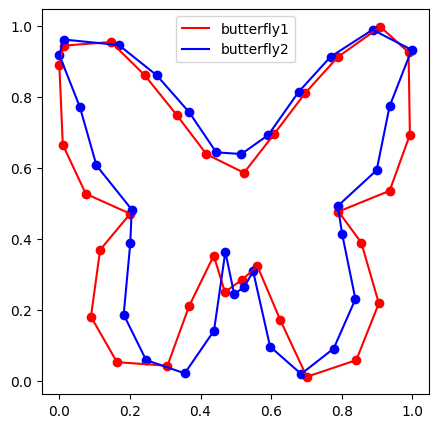

In [4]:
butterfly1 = Butterfly("example_butterfly1", interpolation=512, interpolation_type="linear")
butterfly2 = Butterfly("example_butterfly2", interpolation=512, interpolation_type="linear")

n_training_sample_pts = 32
butterfly1_sample = butterfly1.sample(n_training_sample_pts)
butterfly2_sample = butterfly2.sample(n_training_sample_pts)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = plot_shape_with_pts(ax, butterfly1_sample, color="r", label="butterfly1")
ax = plot_shape_with_pts(ax, butterfly2_sample, color="b", label="butterfly2")
ax.legend()

In [26]:
config = get_config()
config.sde.s0 = butterfly1
config.sde.kappa = 0.08
config.sde.sigma = 0.03
config.training.n_pts = n_training_sample_pts
trainer = TrainerModule(
    config
)

(16, 100, 64)


<Axes: xlabel='$x$', ylabel='$y$'>

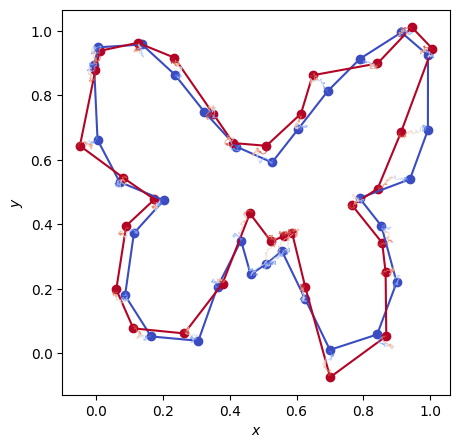

In [27]:
xss, tss, _ = next(trainer.dataloader)
print(xss.shape)
xs = butterfly1_sample[None, :, :] + xss[0].reshape(100, n_training_sample_pts, 2)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_trajectories(ax, xs, target=butterfly1_sample, plot_target=False, cmap_name="coolwarm")

In [28]:
trainer.train_model(
    pretrained=False,
    load_dir="/home/gefan/Projects/scoreoperator/src/pretrained",
    prefix="butterfly_eulerian_32pts100"
)

Training: 100%|██████████| 100/100 [02:48<00:00,  1.68s/epoch, Epoch=99, eval_loss=30.6434, train_loss=30.6324]


In [15]:
def est_score(t, x):
    x_ = jnp.expand_dims(x, axis=0)
    t_ = jnp.expand_dims(t, axis=0)
    score = trainer.infer_model((x_, t_))
    return score.squeeze() 

score_fn = lambda t, x: est_score(t, x.reshape(-1, 2)).flatten()

<Axes: xlabel='$x$', ylabel='$y$'>

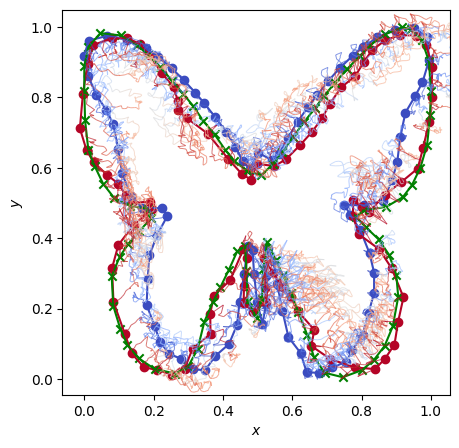

In [23]:
n_eval_sample_pts = 90
x0 = (butterfly2.sample(n_eval_sample_pts) - butterfly1.sample(n_eval_sample_pts)).flatten()
ts = jnp.linspace(0.0, 1.0, 200)
xs, _ = trainer.diffuser.solve_reverse_bridge_sde(rng_key=jax.random.PRNGKey(4), x0=x0, ts=ts, score_fn=score_fn)
xs = xs.reshape(-1, n_eval_sample_pts, 2)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_trajectories(ax, (xs+butterfly1.sample(n_eval_sample_pts)[None, ...]), target=butterfly1.sample(n_eval_sample_pts), plot_target=True, cmap_name="coolwarm")